In [4]:
import hypertools as hyp
from qmvpa import utils
from data_loader import load_cifar
from sklearn.model_selection import train_test_split
import os
import sys 
import numpy as np
# import resnet
import matplotlib.pyplot as plt 
import seaborn as sns 
from dep.read_acts_keras import get_activations
from dep.utils import subset_units

%matplotlib inline 
# %matplotlib notebook
%autosave 5
sns.set(style = 'white', font_scale = 1.2, rc={"lines.linewidth": 2.5})

log_root = '/tigress/qlu/logs/keras-resnet/log'

data_name = 'cifar10'
model_name = 'resnet18'

# load data 
_, X_test, _, Y_test, _, y_test, data_info = load_cifar(data_name)
[n_classes, img_rows, img_cols, img_channels] = data_info
n_test_egs = len(y_test)
y_test_ids = np.argsort(np.ravel(y_test))

# define params 
n_subjs = 5
log_epochs = np.round(np.logspace(0,2,10))
log_epochs = np.insert(log_epochs, 0, 0).astype(int)

Autosaving every 5 seconds


In [5]:
layer_selected = [2, 10, 17, 25, 32, 40, 47, 55, 62, 66]
window_size = 1000
n_max_units = 500
rdm_len = np.shape(y_test)[0] // window_size

In [6]:
# compute all RDMs
rdm_le = []
acts_le = []
# loop over layers 
for l in layer_selected:
    print('Layer %d: ' % l)
    acts_e = []
    rdm_e = []
    # loop over epoches  
    for e in log_epochs:
        # activation log dir 
        print('%d ' % e, end='')
        rdm_avg = np.zeros((rdm_len, rdm_len))
        for subj_id in range(n_subjs):
            log_dir = os.path.join(log_root, data_name, model_name, 'subj%.2d' % (subj_id))
            acts_path = os.path.join(log_dir, 'epoch_%.3d' % e, 'activations')
            acts_path_l = os.path.join(acts_path, 'layer_%.3d.npy' % (l))

            # load activity 
            loaded_acts = np.load(acts_path_l)
            loaded_acts = np.reshape(loaded_acts, [n_test_egs, -1])

            # subset units 
            n_units = np.shape(loaded_acts)[1]
            if n_units > n_max_units: 
                loaded_acts = subset_units(loaded_acts, n_max_units)

            # use that to order X
            sloaded_acts = loaded_acts[y_test_ids, :]
            asloaded_acts = utils.window_avg(sloaded_acts, window_size)
            
            # accumulate RDM
            rdm_avg += np.corrcoef(asloaded_acts) / n_subjs
            
        # done all subjects...
        rdm_e.append(rdm_avg)
#             acts_e.append(asloaded_acts)
    # done all epoches...
    print()
    rdm_le.append(rdm_e)
#     acts_le.append(acts_e)

Layer 2: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 10: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 17: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 25: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 32: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 40: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 47: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 55: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 62: 
0 1 2 3 5 8 13 22 36 60 100 
Layer 66: 
0 1 2 3 5 8 13 22 36 60 100 


Text(0.5,0,'Training epoches')

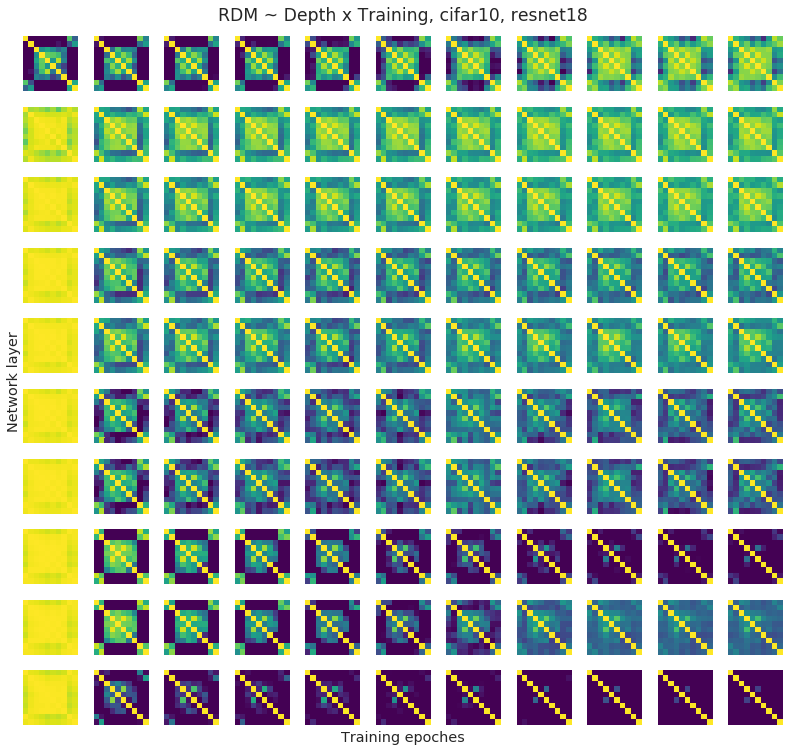

In [7]:
%matplotlib inline 
sns.set(style = 'white', font_scale = 1.2, rc={"lines.linewidth": 2.5})

n_layers = len(layer_selected)
n_epoches = len(log_epochs)
figsize = (n_epoches, n_layers)

# n_epoches = 4
# n_layers = 3

f, axs = plt.subplots(n_layers, n_epoches, figsize = figsize, 
                      sharex=True,sharey=True)
for l in range(n_layers):
    for e in range(n_epoches):
        sns.heatmap(
            rdm_le[l][e], 
            cmap='viridis', square = True, 
            vmax=1, vmin=0, 
            xticklabels = False, yticklabels = False, cbar=False, 
            ax = axs[l,e]
        )
f.tight_layout()

f.suptitle('RDM ~ Depth x Training, %s, %s' % (data_name, model_name), y = 1.02)
f.text(0, 0.5, 'Network layer', va='center', rotation='vertical')
f.text(0.5, 0, 'Training epoches', ha='center')